<a href="https://colab.research.google.com/github/HninSu-15/Spam-Text-Classification/blob/main/SpemEmail_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Spam Email Detection,


In [3]:
!pip install -q torch pandas pyarrow fastparquet scikit-learn nltk huggingface_hub matplotlib


Step 1 : Import required Libraries

In [3]:
import torch

import torch.nn as nn

import torch.optim as optim

import nltk

import regex as re

import pandas as pd

import numpy as np



from matplotlib import pyplot as plt

from nltk.corpus import stopwords

from torch.utils.data import DataLoader, Dataset

from collections import Counter

Step 2 : Load the Dataset

In [4]:
from datasets import load_dataset
dataset = load_dataset("Deysi/spam-detection-dataset")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

data/train-00000-of-00001-daf190ce720b3d(…):   0%|          | 0.00/1.92M [00:00<?, ?B/s]

data/test-00000-of-00001-fa9b3e8ade89a33(…):   0%|          | 0.00/663k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8175 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2725 [00:00<?, ? examples/s]

Step 3 : Text Preprocessing

In [5]:
dataset
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()

In [6]:
dataset.shape

{'train': (8175, 2), 'test': (2725, 2)}

In [7]:
df_train.head(5)

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam


In [8]:
df_train['label'].value_counts()

,count
label,
spam,4125
not_spam,4050


code first line : downloads the common english words like "the, is ,and ,to called stopwords, they don't give meaning to sentences

sec line : load english stopwords and convert into a set for quick lookup

In [19]:

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data Cleaning Process

-convert lowercase
-reomove non-alphanumeric( except spaces)
-remove stopwords ( stop_words variable)

Make Sure to add \s , if not remove everything except letters and numbers also white space , if so stopwords could never be detected or removed. I forget "\s" so , stopwords does not remove in clean data , it has big effect the model performance, the model's loss rate very big and can not detect well.

In [20]:
def clean_data(text):
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]','',text)
  words = [w for w in text.split() if w not in stop_words]
  return ' '.join(words)

In [21]:
# EXample
stop_w  = set(stopwords.words('english'))
text = "hey I am looking for Xray baggage datasets "
tokens = text.lower().split()
filtered = [w for w in tokens if w not in stop_w]
# Output: ['sample', 'sentence', 'stop', 'words']
print (filtered)

['hey', 'looking', 'xray', 'baggage', 'datasets']


Apply the clean_data funtion to "text" column and store preprocessed text in the clean_text column

In [22]:
df_train['clean_data'] =df_train['text'].apply(clean_data)
df_test['clean_data'] = df_test['text'].apply(clean_data)


Map the categrical column to numerical vlaues so that "spam" map to 1 and " not_spam" maps to 0

In [23]:
print(df_train['label'].unique())

['not_spam' 'spam']


In [24]:
df_train['label'] = df_train['label'].map({"spam": 1, "not_spam": 0}).astype("float32")
df_test['label']  = df_test['label'].map({"spam": 1, "not_spam": 0}).astype("float32")


Step 4 : Tokenization and vocabulary

code line 1 : split the sentence into words

line 3 : get all text from the training data

line 4 : create a list of all tokens in the dataset

line 5 : assign a number to each word (start index 2)

line 6&7 : Special tokens , <PAD> -padding token, fill empty space to make all sequence equal length [0,not real word,placeholder  <UNK> -unknown token, replaces words not found in own vocablary, [1-helps avoid errors during prediction]

In [25]:
df_train.head(10)

,text,label,clean_data
0,hey I am looking for Xray baggage datasets can...,0.0,hey looking xray baggage datasets provide
1,"""Get rich quick! Make millions in just days wi...",1.0,get rich quick make millions days new revoluti...
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,1.0,urgent message wont believe offer hey yeah eye...
3,[Google AI Blog: Contributing Data to Deepfake...,0.0,google ai blog contributing data deepfake dete...
4,Trying to see if anyone already has timestamps...,0.0,trying see anyone already timestamps key event...
5,Bridging the gap between artificial intelligen...,0.0,bridging gap artificial intelligence business ...
6,hi all any good leads on datasets for fuel pri...,0.0,hi good leads datasets fuel prices ad fuel con...
7,"\n\nHi everyone,\n\nFor my thesis I'm looking...",0.0,hi everyone thesis im looking daily count subs...
8,I'm looking for a large dataset of n-grams (pr...,0.0,im looking large dataset ngrams preferably 4gr...
9,Check out these amazing weight loss pills! The...,1.0,check amazing weight loss pills guaranteed she...


In [26]:
def tokenize(text):

    return text.split()



train_texts = df_train['clean_data']

all_tokens = [token for text in train_texts for token in tokenize(text)]

vocab = {word: i+2 for i, word in enumerate(Counter(all_tokens))} # start from 2

vocab['<PAD>'] = 0

vocab['<UNK>'] = 1

Step 5. Instantiate the dataset ( preprocessing before training model)

code : prepare to train the model, ensures every sentence has exactly 50 numbers because neural network can process variable length text


In [27]:
def encode(text, max_len=50):

        tokens = tokenize(text)

        ids = [vocab.get(t, 1) for t in tokens]

        if len(ids) < max_len:

                ids += [0] * (max_len - len(ids))

        else:

                ids = ids[:max_len]

        return ids

Think of this as a library bookshelf:

__init__ → places books and their labels on the shelf

__len__ → tells how many books are on the shelf

__getitem__ → lets you pick a book by number

Your model later takes the books one batch at a time for learning.

In [28]:
class SpamDataset(Dataset):

        def __init__(self, texts, labels):

                self.texts = [torch.tensor(encode(t), dtype=torch.long) for t in texts]

                self.labels = torch.tensor(labels, dtype=torch.float32)



        def __len__(self):

                return len(self.texts)



        def __getitem__(self, idx):

                return self.texts[idx], self.labels[idx]

In [29]:
train_texts = df_train['clean_data']

train_labels = df_train['label'].to_numpy(copy=True)



test_texts = df_test['clean_data']

test_labels = df_test['label'].to_numpy(copy=True)

Think of your model like a student:

The Dataset organizes the lessons (text + label).

The DataLoader delivers lessons 32 at a time.

shuffle=True gives lessons in a random order each time → better learning.

Testing is orderly → no shuffling.

In [30]:
train_ds = SpamDataset(train_texts, train_labels)

test_ds = SpamDataset(test_texts, test_labels)



train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

test_dl = DataLoader(test_ds, batch_size=32)

Step 6 "Define the model

Uses embedding to understand words ( each word's meaning)

Usees LSTM to understand sentence structure (full sentence)

Uses Linear+Sigmod to produce spam probability ( express decision as probabilty)


In [31]:
class SpamClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):  # <-- must be inside the class
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out).squeeze(1)


In [32]:
vocab_size = len(vocab)

model = SpamClassifier(vocab_size)

Step 7. Training


In [152]:
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [153]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

SpamClassifier(
  (embedding): Embedding(22754, 64, padding_idx=0)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Train the model 5 epoches , calculate loss b using criterion, compute the gradients using loss.backwards and then update the model parameters usingn the optimizer

Average loss is calculated and print at the end of each epoch

In [160]:
epochs = 6

train_losses = []

for epoch in range(epochs):

    model.train()

    train_loss = 0

    for X, y in train_dl:

        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        preds = model(X)

        loss = criterion(preds, y)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss/len(train_dl))

    print(f'Epoch {epoch+1} | Loss: {train_loss/len(train_dl):.4f}')

Epoch 1 | Loss: 0.2665
Epoch 2 | Loss: 0.2263
Epoch 3 | Loss: 0.1333
Epoch 4 | Loss: 0.1257
Epoch 5 | Loss: 0.1062
Epoch 6 | Loss: 0.0873


Visualization of the loss over the number of epochs

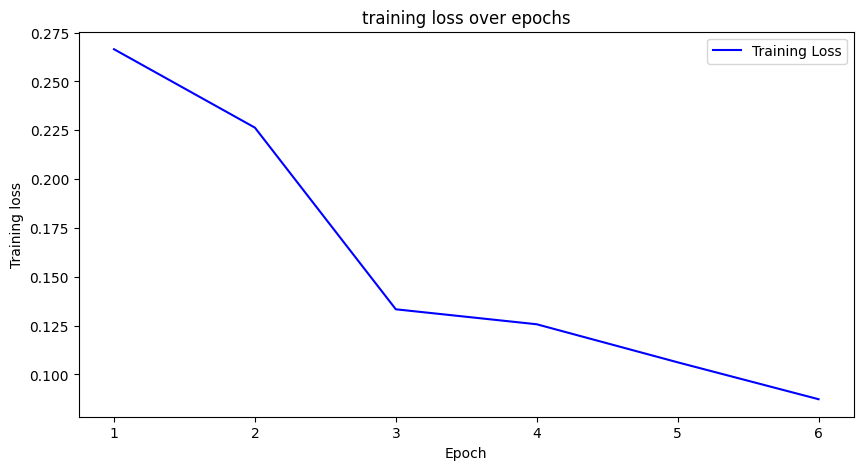

In [161]:
epochs =np.arange(1,len(train_losses)+1)
plt.figure(figsize=(10,5))
plt.plot(epochs,train_losses,label='Training Loss',color='blue')
plt.title('training loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend()

Step 8 : Evaluation

In [163]:
model.eval()
correct,total =0,0
with torch.no_grad():
  for X,y in test_dl:
    X,y =X.to(device),y.to(device)
    preds = model(X)
    preds_cls=(preds>0.5).float()
    correct += (preds_cls==y).sum().item()
    total += y.size(0)
print(f'Final accuracy:{correct/total:.4f}')

Final accuracy:0.9574


Save the model

In [167]:
torch.save(model.state_dict(),'spam_model.pth')

Load the model Locally

In [13]:
from google.colab import files
#files.download('spam_model.pth')
uploaded = files.upload()

Saving spam_model.pth to spam_model.pth


Model Deployment

In [39]:
# load the model locally
# Make sure you have the same model class and vocab
model = SpamClassifier(vocab_size=len(vocab))
model.load_state_dict(torch.load('spam_model.pth', map_location='cpu'))  # use map_location='cpu' if no GPU
model.eval()


SpamClassifier(
  (embedding): Embedding(22754, 64, padding_idx=0)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Test the unseen the data